In [1]:
import pandas as pd
import numpy as np

In [2]:
distribution_folder = '70_PERCENT_CONFIDENCE_53K_INDIVIDUAL_HCP_AUTHORS_2020_NO_KEYWORDS_WITH_RETWEETS_{}_TOPICS'

distribution_num_topics = [15, 20, 25, 30]

distribution_folders = [distribution_folder.format(num_topics) for num_topics in distribution_num_topics]

num_words_to_retrieve = 100
word_file_name = 'top_100_terms.csv'

In [3]:
dist_dfs = {}

for num_topics, dist_folder in zip(distribution_num_topics, distribution_folders):
    dist_dfs[num_topics] = pd.read_csv(f'{dist_folder}/{word_file_name}', nrows=num_words_to_retrieve)

In [4]:
def jaccard_score(series1, series2):
    series1_set = set(series1)
    series2_set = set(series2)
    return len(series1_set & series2_set) / len(series1_set | series2_set)

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

jaccard_threshold = 0.3

G = nx.Graph()

adjacent_distribution_pairs = [(distribution_num_topics[i], distribution_num_topics[i + 1]) for i in range(0, len(distribution_num_topics) - 1)]
        
nodes_and_edges_to_sort = []
    
for num_topics1, num_topics2 in adjacent_distribution_pairs:
    df1 = dist_dfs[num_topics1]
    df2 = dist_dfs[num_topics2]

    # THE FIRST NODES TO BE ADDED ARE THE ONES WITH THE STRONGEST CONNECTIONS
    
    for n1 in range(num_topics1):
        for n2 in range(num_topics2):
            j_score = jaccard_score(df1[f'topic{n1}'], df2[f'topic{n2}'])
            if j_score > jaccard_threshold:
                node1_name = f'dist{num_topics1}_topic{n1}'
                node2_name = f'dist{num_topics2}_topic{n2}'
                
                nodes_and_edges_to_sort.append((j_score, node1_name, node2_name, num_topics1, num_topics2, n1, n2))
                
nodes_and_edges_to_add = sorted(nodes_and_edges_to_sort, key=lambda tup: tup[0], reverse=True)

for j_score, node1_name, node2_name, num_topics1, num_topics2, n1, n2 in nodes_and_edges_to_add:
        G.add_node(node1_name, dist=num_topics1, image=mpimg.imread(f'{distribution_folder.format(num_topics1)}/updated_wordclouds/topic{n1}.png'))
        G.add_node(node2_name, dist=num_topics2, image=mpimg.imread(f'{distribution_folder.format(num_topics2)}/updated_wordclouds/topic{n2}.png'))
        G.add_edge(node1_name, node2_name, jaccard=j_score)

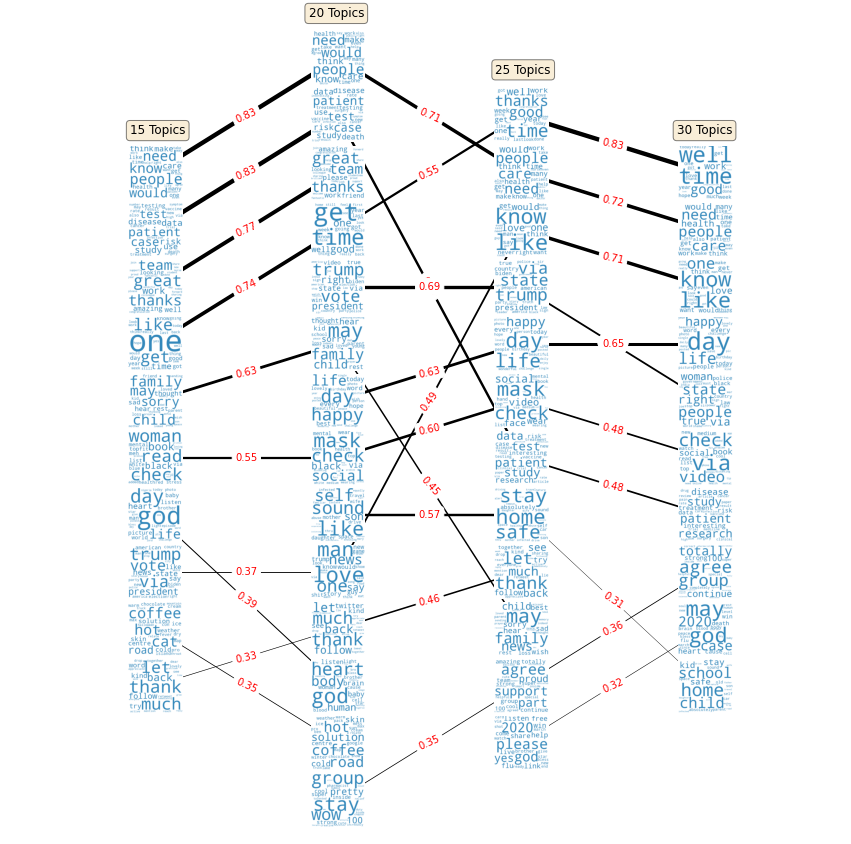

In [6]:
edges = G.edges()

weights = np.array([G[u][v]['jaccard'] for u, v in edges])
normalized_weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))

pos = nx.multipartite_layout(G, subset_key='dist')

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot()
nx.draw_networkx(G, pos, width=normalized_weights * 4 + 0.4, ax=ax, with_labels=False)
nx.draw_networkx_edge_labels(G, pos, edge_labels={edge: '{:.2f}'.format(value) for edge, value in nx.get_edge_attributes(G, 'jaccard').items()}, font_color='red')


plt.xlim(-1.5, 1.5)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.05 # this is the image size
p2=piesize/2.0
for n in G:
    xx,yy=trans(pos[n]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])
    a.set_aspect('equal')
    a.imshow(G.nodes[n]['image'])
    a.axis('off')
ax.axis('off')


ax.text(-1.06, 0.68, '15 Topics', fontsize='large', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(-0.42, 0.95, '20 Topics', fontsize='large', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.25, 0.82, '25 Topics', fontsize='large', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.9, 0.68, '30 Topics', fontsize='large', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

In [7]:
nx.get_edge_attributes(G, 'jaccard')

{('dist15_topic0', 'dist20_topic0'): 0.8348623853211009,
 ('dist20_topic0', 'dist25_topic0'): 0.7094017094017094,
 ('dist15_topic8', 'dist20_topic8'): 0.8348623853211009,
 ('dist20_topic8', 'dist25_topic8'): 0.5748031496062992,
 ('dist25_topic1', 'dist30_topic1'): 0.8348623853211009,
 ('dist25_topic1', 'dist20_topic1'): 0.5503875968992248,
 ('dist15_topic6', 'dist20_topic6'): 0.7699115044247787,
 ('dist15_topic1', 'dist20_topic1'): 0.7391304347826086,
 ('dist25_topic0', 'dist30_topic0'): 0.7241379310344828,
 ('dist25_topic2', 'dist30_topic2'): 0.7094017094017094,
 ('dist25_topic2', 'dist20_topic2'): 0.4925373134328358,
 ('dist20_topic3', 'dist25_topic3'): 0.6949152542372882,
 ('dist25_topic3', 'dist30_topic3'): 0.4925373134328358,
 ('dist25_topic16', 'dist30_topic16'): 0.6528925619834711,
 ('dist25_topic16', 'dist20_topic16'): 0.6260162601626016,
 ('dist15_topic9', 'dist20_topic9'): 0.6260162601626016,
 ('dist20_topic9', 'dist25_topic9'): 0.4492753623188406,
 ('dist20_topic5', 'dist25_

In [8]:
# Prepare input for R jaccard code (testing statistical significance)

def get_binary_vectors(dist1, topic1, dist2, topic2):
    word_set1 = set(dist_dfs[dist1]['topic{}'.format(topic1)])
    word_set2 = set(dist_dfs[dist2]['topic{}'.format(topic2)])
    union_list = list(set(word_set1) | set(word_set2))
    binary_vector1 = []
    binary_vector2 = []
    for word in union_list:
        if word in word_set1:
            binary_vector1.append(1)
        else:
            binary_vector1.append(0)
        if word in word_set2:
            binary_vector2.append(1)
        else:
            binary_vector2.append(0)
    return binary_vector1, binary_vector2

In [9]:
def get_r_vector_string(lst):
    return 'c({})'.format(', '.join([str(num) for num in lst]))

In [10]:
import subprocess

for tup, val in nx.get_edge_attributes(G, 'jaccard').items():
    dist1 = tup[0]
    dist1 = dist1[dist1.index('t') + 1:dist1.index('t') + 3]
    dist1 = int(dist1)

    topic1 = tup[0]
    topic1 = topic1[topic1.index('c') + 1:]
    topic1 = int(topic1)

    dist2 = tup[1]
    dist2 = dist2[dist2.index('t') + 1:dist2.index('t') + 3]
    dist2 = int(dist2)

    topic2 = tup[1]
    topic2 = topic2[topic2.index('c') + 1:]
    topic2 = int(topic2)


    # Define command and arguments
    command = r'E:\R\R-4.1.0\bin\Rscript.exe'
    path2script ='jaccard_statistical_significance.R'

    binary_vectors = get_binary_vectors(dist1, topic1, dist2, topic2)
    
    # Variable number of args in a list
    args = [get_r_vector_string(binary_vectors[0]), get_r_vector_string(binary_vectors[1])]

    # Build subprocess command
    cmd = [command, path2script] + args

    x = subprocess.check_output(cmd, universal_newlines=True)
    pvalue_str = x[x.index('$pvalue\n[1] ')+len('$pvalue\n[1] '):]
    pvalue_str = pvalue_str[:pvalue_str.index('\n')]
    pvalue = float(pvalue_str)
    
    print(tup, val, pvalue)

('dist15_topic0', 'dist20_topic0') 0.8348623853211009 0.388
('dist20_topic0', 'dist25_topic0') 0.7094017094017094 0.065
('dist15_topic8', 'dist20_topic8') 0.8348623853211009 0.394
('dist20_topic8', 'dist25_topic8') 0.5748031496062992 0.009
('dist25_topic1', 'dist30_topic1') 0.8348623853211009 0.34
('dist25_topic1', 'dist20_topic1') 0.5503875968992248 0.001
('dist15_topic6', 'dist20_topic6') 0.7699115044247787 0.181
('dist15_topic1', 'dist20_topic1') 0.7391304347826086 0.112
('dist25_topic0', 'dist30_topic0') 0.7241379310344828 0.102
('dist25_topic2', 'dist30_topic2') 0.7094017094017094 0.074
('dist25_topic2', 'dist20_topic2') 0.4925373134328358 0.001
('dist20_topic3', 'dist25_topic3') 0.6949152542372882 0.053
('dist25_topic3', 'dist30_topic3') 0.4925373134328358 0.001
('dist25_topic16', 'dist30_topic16') 0.6528925619834711 0.029
('dist25_topic16', 'dist20_topic16') 0.6260162601626016 0.015
('dist15_topic9', 'dist20_topic9') 0.6260162601626016 0.02
('dist20_topic9', 'dist25_topic9') 0.4